In [1]:
from matplotlib import pyplot as plt

from matplotlib.colors import TwoSlopeNorm

In [2]:
import pygsti
from math import sqrt
import numpy as np

import pygsti.modelmembers as mm
import pygsti.models.modelconstruction as mc


from pygsti.models import ExplicitOpModel
from pygsti.baseobjs import ExplicitStateSpace

from numpy import pi, array

from pygsti import unitary_to_process_mx

# Create qudit model

In [5]:
dim = 4

In [6]:
qudit_space = ExplicitStateSpace(['D0'], udims=[dim], types='Q')

# std basis is for all matrices that are one-hot.
# gm is the Gell-mann basis for the dim x dim space
# basis = 'std' # Using the standard basis as its the most generic/convenient for arbitrary dimensions
basis = 'gm' # The Gell-Mann basis seems to work best with the GST constructs
# basis = 'pp' # The Pauli-product basis is also an option

simulator = 'matrix' # Map doesn't have a product method which is needed for fiducial selection.
qudit_model = ExplicitOpModel(qudit_space, basis=basis, simulator='matrix') 

# Add initial states, measurement POVMs

In [7]:
rho0 = np.zeros((dim,dim))
rho0[0,0] = 1
qudit_model['rho0'] = pygsti.change_basis(rho0.flatten(), 'std', basis)

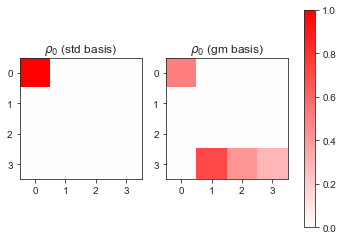

In [8]:
fig, axes = plt.subplots(1,2)
axes[0].set_title(r'$\rho_0$ ' +  f'(std basis)')
axes[0].imshow(rho0, cmap='bwr', norm=TwoSlopeNorm(vcenter=0))
axes[1].set_title(r'$\rho_0$ ' +  f'({basis} basis)')
# axes[1].spy(np.reshape(qudit_model['rho0'], (dim, dim)))
im = axes[1].imshow(np.reshape(qudit_model['rho0'], (dim, dim)), cmap='bwr', norm=TwoSlopeNorm(vcenter=0, vmax=1))
colorbar = fig.colorbar(im, ax=axes.ravel().tolist())

In [9]:
# For plotting calculate the number of rows and columns we need to represent the dim x dim projectors.
n_rows = int(np.floor(np.sqrt(dim)))
n_columns = int(np.ceil(dim / n_rows))

In [10]:
# Simply use projective measurement of computational basis states.
projectors = [np.diag(np.eye(dim)[:,k]) for k in range(dim) ]
projectors_final = [pygsti.change_basis(np.reshape(p, (dim*dim, 1)), "std", basis) for p in projectors]

qudit_model['Mdefault'] = mm.povms.UnconstrainedPOVM(
    [(str(k), p) for k, p in zip(range(dim), projectors_final)], evotype='default', state_space=qudit_space)

Text(0.5, 1, 'POVM effects  (std basis)')

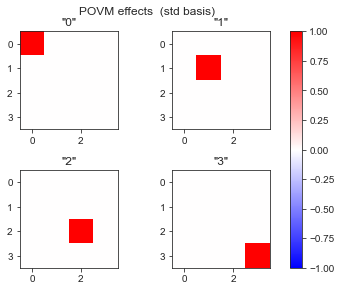

In [11]:
fig, axes = plt.subplots(n_rows,n_columns)
axes_l = axes.flatten()
ims = np.empty_like(axes_l)


norm = TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)

for k, (projector, ax) in enumerate(zip(projectors, axes_l)):    
    ax.set_title(f'"{k}"')
    ims[k] = ax.imshow(np.reshape(projector, (dim, dim)), cmap='bwr', norm=norm)

fig.tight_layout()
colorbar = fig.colorbar(ims[0], ax=axes.ravel().tolist())

for ax in axes_l[dim:]:
    ax.remove()

fig.suptitle('POVM effects  (std basis)', y=1)

In [12]:
vmin = np.min([p for p in projectors_final])
vmax = np.max([p for p in projectors_final])
norm = TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)

Text(0.5, 1, 'POVM effects (gm basis)')

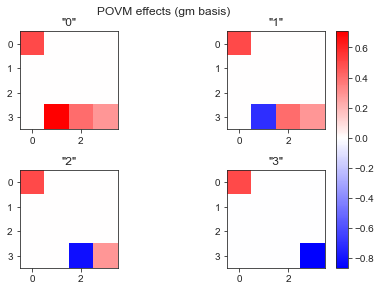

In [13]:
fig, axes = plt.subplots(n_rows,n_columns)
axes_l = axes.flatten()
ims = np.empty_like(axes_l)
for k, (projector) in enumerate(projectors_final):
    ax = axes_l[k]
    
    ax.set_title(f'"{k}"')
    ims[k] = ax.imshow(np.reshape(projector, (dim, dim)), cmap='bwr', norm=norm)
    
fig.tight_layout()
# fig.subplots_adjust(wspace=-0.6)

colorbar = fig.colorbar(ims[0], ax=axes[..., -1].ravel().tolist())
for ax in axes_l[dim:]:
    ax.remove()
fig.suptitle(f'POVM effects ({basis} basis)', y=1)

# Define operations and add to model

In [14]:
from itertools import permutations
from scipy.linalg import expm

def R(theta, phi):
    """SU(2) rotation operation, rotating through an angle theta with axis of rotation in the xy-plane chosen by phi.
    
    Arguments:
        theta (float) : Angle of rotation
        phi (float) : Axis of rotation (0 degrees = rotation about +x-axis, pi/2 -> rotation about +y axis.)
        
    References:
        F. T. Arecchi, E. Courtens, R. Gilmore, H. Thomas, Atomic Coherent States in Quantum Optics. Phys Rev A. 6, 2211–2237 (1972).
    """
#     return np.array([
#         [np.cos(theta), -np.sin(theta)],
#         [np.sin(theta), np.cos(theta)]
#     ])
    sigma_x = 1/2*np.array([[0, 1],[1, 0]])
    sigma_y = 1/2*np.array([[0, -1j],[1j, 0]])
    return expm(-1j*theta*(sigma_x*np.sin(phi) - sigma_y*np.cos(phi)))

def generate_Givens(theta, phi, dim, m0 = 0, m1 = 1):
    assert (0 <= m0 < dim) and (0 <= m1 < dim), "Levels outside of Hilbert space."
    assert m0 != m1, "Levels must differ by at least one."
    rot = R(theta, phi)
    
    # Create an identity and change the necessary elements later
#     if np.isclose(phi, 0) or np.isclose(phi, np.pi):
#         GG = np.identity(dim, dtype='float64')
#         rot = rot.astype('float64')
#     else:
    GG = np.identity(dim, dtype='complex128')
    
    
    # Replace elements of matrix to create Givens rotation between levels m0 and m1. 
    for k, i in enumerate([m0, m1]):
        for kk, j in enumerate([m0, m1]):
            GG[i, j] = rot[k, kk]
    return GG

Define our operations as $\pi$- or $\pi/2$-rotations between levels about the $x$- and $y$-axes.  
We define the operations in the standard matrix basis then convert to the model basis of choice.  

Question 1: Should casting between bases happen automatically? e.g. if I define an operator in the standard basis and then attach it to a model in the Pauli-product basis, should it be transformed at that point in time?  
~~Question 2: `unitary_to_process_mx(mx)`  maintains the type of `mx`. In most cases `mx` must be a complex unitary matrix, but the process matrix must always have real values. Should the process matrix be automatically cast to a real-valued matrix?~~ This no longer seems to be an issue...

In [15]:
rotation_angle = np.pi/2 # pi = X, pi/2 = sqrt(X)

qudit_model['Gi'] = unitary_to_process_mx(np.eye(dim))
for l in range(dim-1):
    # Build 2-level x and y  pi-rotations for all adjacent levels.
    qudit_model[f'Gx{l}{l+1}'] = pygsti.change_basis(unitary_to_process_mx(
                                    generate_Givens(rotation_angle, 0, dim, l, l+1)), 'std', basis)
    
    qudit_model[f'Gy{l}{l+1}'] = pygsti.change_basis(unitary_to_process_mx(
                                    generate_Givens(rotation_angle, np.pi/2, dim, l, l+1)), 'std', basis)

## Try to convert operators to "full TP", "TP" and "CPTP"  
The operators must be described in either the Pauli-product or Gell-mann basis, make sure to convert them prior to this section.

In [16]:
try:
    for label, op in qudit_model.operations.items():
        mm.operations.convert(op, 'full TP', basis)
    print("Success!")
except:
    print("Failed to convert...")

Success!


In [17]:
try:
    for label, op in qudit_model.operations.items():
        mm.operations.convert(op, 'TP', basis)
    print("Success!")
except:
    print("Failed to convert...")

Success!


In [18]:
try:
    for label, op in qudit_model.operations.items():
        mm.operations.convert(op, 'CPTP', basis)
    print("Success!")
except:
    print("Failed to convert...")

Success!


# Create a GST gate set

Algorithm to find fiducials does not work.

In [19]:
import pygsti.algorithms.fiducialselection as fidsel
import pygsti.algorithms.germselection as germsel

## Laissez faire

In [20]:
fiducial_alg = 'grasp'
prepFiducials, measFiducials = fidsel.find_fiducials(qudit_model, max_fid_length=dim, algorithm=fiducial_alg,
                                                     algorithm_kwargs={'iterations':1}, verbosity=3)

Using GRASP algorithm.
Complete initial fiducial set succeeds.
Now searching for best fiducial set.
Starting fiducial list optimization. Lower score is better.
Starting iteration 1 of 1.
Initial construction:
['{}', 'Gx12Gx23Gy01Gy01', 'Gy12Gy23Gy12Gx01', 'Gx23Gy12Gy01Gy12', 'Gy23Gy12Gy01Gy23', 'Gy23Gy12Gx01Gy12', 'Gx01Gy23Gy12Gy23', 'Gy01Gx12Gy23Gy23', 'Gy12Gy01Gx23Gx12', 'Gy01Gy01Gx12Gy01', 'Gx12Gy01Gx12Gx23', 'Gx01Gx23Gx12Gx23', 'Gx01Gy12Gx01Gy23', 'Gy01Gy12Gy12Gx23', 'Gy01Gx23Gx12Gy23', 'Gy12Gy01Gy12Gy12']
Local optimum:
['{}', 'Gy01', 'Gx01Gy12', 'Gx01Gx12Gx12', 'Gy01Gy01Gx12', 'Gx01Gx01Gy12Gy12', 'Gx01Gx12Gy01Gy01', 'Gx01Gx12Gx23Gx23', 'Gx01Gy12Gx01Gx01', 'Gx01Gy12Gy12Gy12', 'Gx01Gy12Gy12Gx23', 'Gx01Gy12Gy12Gy23', 'Gx01Gy12Gx23Gx23', 'Gx01Gy12Gy23Gy23', 'Gy01Gy01Gy12Gx23', 'Gy01Gy01Gy12Gy23']
Finished iteration 1 of 1.
Preparation fiducials:
['{}', 'Gy01', 'Gx01Gy12', 'Gx01Gx12Gx12', 'Gy01Gy01Gx12', 'Gx01Gx01Gy12Gy12', 'Gx01Gx12Gy01Gy01', 'Gx01Gx12Gx23Gx23', 'Gx01Gy12Gx01Gx01', '

In [ ]:
germ_alg = 'greedy'
candidate_germ_counts = {3:'all upto'}
germs = germsel.find_germs(qudit_model, candidate_germ_counts=candidate_germ_counts, algorithm=germ_alg, verbosity=3)

Using greedy algorithm.
Complete initial germ set succeeds on all input models.
Now searching for best germ set.
Starting germ set optimization. Lower score is better.
  Outer iteration: 1 of 1538 amplified, 7 germs


Now that we have germs and fiducials, we can construct the list of experiments we need to perform in
order to do GST. The only new things to provide at this point are the sizes for the experiments we want
to perform (in this case we want to perform between 0 and 256 gates between fiducial pairs, going up
by a factor of 2 at each stage).

In [34]:
maxLengths = [2**n for n in range(3)]
listOfExperiments = pygsti.circuits.create_lsgst_circuits(
    qudit_model, prepFiducials, measFiducials, germs, maxLengths)

In [42]:
listOfExperiments.write(f'./experiments/exp_d{dim}_germs_{germ_alg}_fids_{fiducial_alg}.json')

ValueError: Cannot determine format from extension of filename: ./experiments/exp_d3_germs_greedy_fids_grasp

## More control

In [ ]:
slackPrepFids, slackMeasFids = fidsel.find_fiducials(qudit_model,
                                                     algorithm='slack',
                                                     # algorithm='grasp',
                                                     algorithm_kwargs={
                                                        'slack_frac': 0.25,
#                                                         'iterations': 100
                                                     },
                                                    )

In [ ]:
graspPrepFids, graspMeasFids = fidsel.find_fiducials(qudit_model,
                                                     algorithm='grasp',
                                                     algorithm_kwargs={
                                                        'iterations': 100
                                                     },
                                                     max_fid_length=3,
                                                     verbosity=1
                                                    )

In [ ]:
graspGerms = germsel.find_germs(qudit_model,
                                algorithm='grasp',
                                candidate_germ_counts={3:'all upto'},
                                algorithm_kwargs={'iterations': 100},
                               verbosity=3)

In [ ]:
maxLengths = [2**n for n in range(3)]
listOfExperiments = pygsti.circuits.create_lsgst_circuits(
    qudit_model, graspPrepFids, graspMeasFids, graspGerms, maxLengths)

## Pre-defined (from qubit case)

In [28]:
fiducialPrep = pygsti.circuits.to_circuits(
    [(),
     ('Gx01',),
     ('Gx01','Gx01','Gx01')
    ])

fiducialMeasure = pygsti.circuits.to_circuits(
    [
    (),
    ('Gx01',),
    ]
)

maxLengths = [1,2,4]

germs = pygsti.circuits.to_circuits(
[('Gi',),
 ('Gx01',),
 ('Gi', 'Gi', 'Gx01'),
 ('Gi', 'Gx01', 'Gx01'),
]
)

In [21]:
fiducialPrep = pygsti.circuits.to_circuits(
    [(),
     ('Gx01',),
     ('Gy01',),
     ('Gx01', 'Gx12'),
     ('Gy01', 'Gx12'),
     ('Gx01', 'Gy12'),
     ('Gy01', 'Gy12'),
     
     ('Gx01', 'Gx12', 'Gx23'),
     ('Gy01', 'Gx12', 'Gx23'),
     ('Gx01', 'Gy12', 'Gx23'),
     ('Gy01', 'Gy12', 'Gx23'),
     ('Gx01', 'Gx12', 'Gy23'),
     ('Gy01', 'Gx12', 'Gy23'),
     ('Gx01', 'Gy12', 'Gy23'),
     ('Gy01', 'Gy12', 'Gy23'),
    ])

fiducialMeasure = pygsti.circuits.to_circuits(
    [
    (),
    ('Gx01',),
    ]
)

maxLengths = [1,2,4]

germs = pygsti.circuits.to_circuits(
[('Gi',),
 ('Gx01',),

#  ('Gi', 'Gi', 'Gx01'),
#  ('Gi', 'Gx01', 'Gx01'),
]
)

In [21]:
print("%d prep fiducials" % len(fiducialPrep))
print("%d meas fiducials" % len(fiducialMeasure))
print("%d germs" % len(germs))

3 prep fiducials
2 meas fiducials
4 germs


## Create experiment list and dataset

In [58]:
# #generate data template
expList = pygsti.circuits.create_lsgst_circuits(qudit_model.operations.keys(), prepFiducials, measFiducials, germs,  maxLengths)
pygsti.io.write_empty_dataset(f"example_files/dataTemplate_qu{dim}it_maxL={maxLengths[-1]}.txt", expList, 
                              "## Columns = " + ", ".join([f"{k} count" for k in range(dim)]))

At this point **STOP** and create/fill a dataset file using the template written in the above cell.  Then proceed with the lines below to run GST on the data and create (hopefully useful) reports telling you about your gates.

In [59]:
mdl_datagen = qudit_model.depolarize(0.05)
DS = pygsti.data.simulate_data(mdl_datagen, expList, 500, sample_error='multinomial', seed=2018)

# Simulate GST

In [73]:
from pygsti.forwardsims import MapForwardSimulator

In [80]:
qudit_model.sim = MapForwardSimulator(num_atoms=4, param_blk_sizes=(2*(1024)**3,))

In [81]:
# qudit_model.sim = "matrix"

result = pygsti.run_stdpractice_gst(DS,qudit_model,prepFiducials,measFiducials,germs,maxLengths,
                                 verbosity=4, comm=None, mem_limit=12*(1024)**3, modes='CPTP')

--- Circuit Creation ---
   2025 circuits created
   Dataset has 2025 entries: 2025 utilized, 0 requested circuits were missing
-- Std Practice:  Iter 1 of 1  (CPTP) --: 
  --- Iterative GST: Iter 1 of 3  206 circuits ---: 
    Layout creation w/mem limit = 12.00GB
    MapLayout: 1 processors divided into 1 x 1 (= 1) grid along circuit and parameter directions.
       4 atoms, parameter block size limits (2147483648,)
    *** Distributing 4 atoms to 1 atom-processing groups (1 cores) ***
        More atom-processors than hosts: each host gets ~1 atom-processors
        Atom-processors already occupy a single node, dividing atom-processor into 1 param-processors.
    *** Divided 1-host atom-processor (~1 procs) into 1 param-processing groups ***
       Esimated memory required = 0.0GB
    --- chi2 GST ---
      --- Outer Iter 0: norm_f = 567673, mu=1, |x|=2.5651, |J|=10019.9
      --- Outer Iter 1: norm_f = 86417.5, mu=4979.58, |x|=2.60506, |J|=21885
      --- Outer Iter 2: norm_f = 494

KeyboardInterrupt: 

In [78]:
%debug

> /home/maij/Documents/github/pyGSTi/pygsti/forwardsims/distforwardsim.py(455)_compute_processor_distribution()
    453         param_dimensions = (num_params,) * (int(bNp1Matters) + int(bNp2Matters))
    454         param_blk_sizes = (None,) * len(param_dimensions) if (self._pblk_sizes is None) \
--> 455             else self._pblk_sizes[0:len(param_dimensions)]  # automatically set these?
    456 
    457         if self._processor_grid is not None:



ipdb>  self._pblk_sizes


2147483648


ipdb>  q


In [67]:
#Create a report
report_name = f"Example qu{dim}it report"
ws = pygsti.report.construct_standard_report(
    result, report_name, verbosity=3
).write_html(f'example_files/{report_name.replace(" ", "_")}', auto_open=True, verbosity=3)

Running idle tomography
Computing switchable properties
